Dataset Details :

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project. They have graciously provided the workshop organizers with a preliminary version of their dataset to use for this contest.

https://www.kaggle.com/nicolejyt/facialexpressionrecognition

In [24]:
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [91]:
DATASET_PATH = "D:/Digant/Codes/Machine Learning/Datasets/fer2013.csv"
df = pd.read_csv(DATASET_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [82]:
print("Different Values : ",df.Usage.unique())
print(df.Usage.value_counts())

Different Values :  ['Training' 'PublicTest' 'PrivateTest']
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


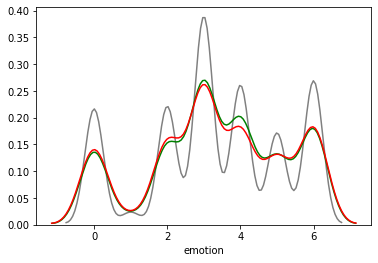

In [72]:
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

sns.distplot(df[df.Usage=="Training"].emotion,bins=7,hist=False,color='grey')

sns.distplot(df[df.Usage=="PublicTest"].emotion,bins=7,hist=False,color='green')

sns.distplot(df[df.Usage=="PrivateTest"].emotion,bins=7,hist=False,color='red')

# The private(validation) and the public(final test) test have the similar distribution of emotion.

<class 'str'>
48


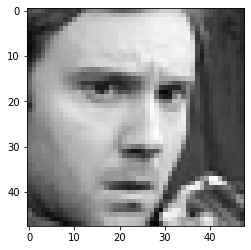

In [70]:
# Checking how one image looks.
img = df.pixels[0]
print(type(img))
img = img.split(" ")
img = list(map(int,img))
IMAGE_SIZE = int(np.sqrt(len(img)))
print(IMAGE_SIZE)
image = np.reshape(img,[IMAGE_SIZE,IMAGE_SIZE])
gray_img = Image.fromarray(image)
plt.imshow(image,cmap='gray')
# gray_img.show()

In [92]:
# The pixels are stored in the form of a string, so we convert them to list first
df['pixels'] = df['pixels'].str.split(" ")

# Convert pixels to numpy arr of image shape 48 x 48 x 1
def convertToIntList(val):
    img_li = list(map(int,val))
    img_arr = np.reshape(img_li,[IMAGE_SIZE,IMAGE_SIZE,1])
    return img_arr

df.pixels = df.pixels.apply(convertToIntList)

In [93]:
# Normalizing pixels
df.pixels = (1/255)*df.pixels

In [95]:
for index, row in df[df.Usage=="Training"].iterrows():
    emotion = row["emotion"]
    pixels = row["pixels"]
    print(emotion)
    print(pixels)
    break

0
[[[0.2745098 ]
  [0.31372549]
  [0.32156863]
  ...
  [0.20392157]
  [0.16862745]
  [0.16078431]]

 [[0.25490196]
  [0.23921569]
  [0.22745098]
  ...
  [0.21960784]
  [0.20392157]
  [0.17254902]]

 [[0.19607843]
  [0.16862745]
  [0.21176471]
  ...
  [0.19215686]
  [0.21960784]
  [0.18431373]]

 ...

 [[0.35686275]
  [0.25490196]
  [0.16470588]
  ...
  [0.28235294]
  [0.21960784]
  [0.16862745]]

 [[0.30196078]
  [0.32156863]
  [0.30980392]
  ...
  [0.41176471]
  [0.2745098 ]
  [0.18039216]]

 [[0.30196078]
  [0.28235294]
  [0.32941176]
  ...
  [0.41568627]
  [0.42745098]
  [0.32156863]]]


In [101]:
np.shape(df.pixels.tolist())

(35887, 48, 48, 1)

In [104]:
from keras.models import Sequential,save_model,load_model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from keras.losses import categorical_crossentropy
from keras.activations import relu 
from keras.optimizers import Adam
from keras.utils import to_categorical

In [113]:
X_train = np.array(df[df.Usage == "Training"].pixels.tolist())
Y_train = to_categorical(df[df.Usage == "Training"].emotion.tolist(), num_classes=7)

X_val = np.array(df[df.Usage == "PrivateTest"].pixels.tolist())
Y_val = to_categorical(df[df.Usage == "PrivateTest"].emotion.tolist(), num_classes=7)

X_test = np.array(df[df.Usage == "PublicTest"].pixels.tolist())
Y_test = to_categorical(df[df.Usage == "PublicTest"].emotion.tolist(), num_classes=7)

In [115]:
model = Sequential()

model.add(Conv2D(48, (3, 3), padding='same', activation='relu',input_shape=(48, 48, 1)))
model.add(Conv2D(48, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(96, (4, 4), padding='same', activation='relu'))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (4, 4), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(7,activation="sigmoid"))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

EPOCHS = 30
batch_size = 128

In [116]:
history = model.fit(x=X_train,y=Y_train,batch_size=batch_size,validation_data=(X_val,Y_val),shuffle=True, verbose=1,epochs=EPOCHS)

Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 23s 807us/step - loss: 1.8177 - acc: 0.2501 - val_loss: 1.8157 - val_acc: 0.2449
Epoch 2/30
28709/28709 [==============================] - 18s 640us/step - loss: 1.7939 - acc: 0.2514 - val_loss: 1.7764 - val_acc: 0.2480
Epoch 3/30
28709/28709 [==============================] - 18s 644us/step - loss: 1.6576 - acc: 0.3327 - val_loss: 1.4844 - val_acc: 0.4113
Epoch 4/30
28709/28709 [==============================] - 19s 647us/step - loss: 1.4291 - acc: 0.4391 - val_loss: 1.3701 - val_acc: 0.4687
Epoch 5/30
28709/28709 [==============================] - 19s 650us/step - loss: 1.2813 - acc: 0.5048 - val_loss: 1.2671 - val_acc: 0.5046
Epoch 6/30
28709/28709 [==============================] - 19s 649us/step - loss: 1.1625 - acc: 0.5528 - val_loss: 1.1948 - val_acc: 0.5386
Epoch 7/30
28709/28709 [==============================] - 19s 651us/step - loss: 1.0674 - acc: 0.5931 - val_loss: 1.1

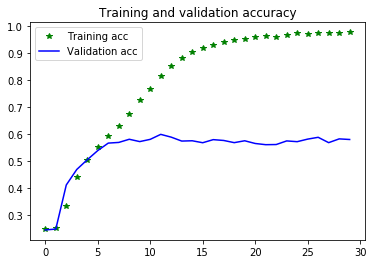

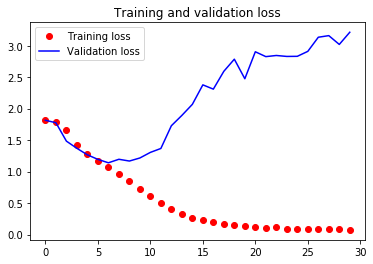

In [117]:
model.save('facial_1')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g*', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()